In [1]:
# import packages 
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from scipy import linalg
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#read in data
fp = os.path.join('data', 'ucsdadvanced.csv')
advanced = pd.read_csv(fp)
fp = os.path.join('data', 'ucsdpergame.csv')
pergame = pd.read_csv(fp)

## Glossary
Rk -- Rank

G -- Games

GS -- Games Started

MP -- Minutes Played

PER -- Player Efficiency Rating

TS% -- True Shooting Percentage
A measure of shooting efficiency that takes into account 2-point field goals, 3-point field goals, and free throws.

eFG% -- Effective Field Goal Percentage; this statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.

3PAr -- 3-Point Attempt Rate
Percentage of FG Attempts from 3-Point Range

FTr -- Free Throw Attempt Rate
Number of FT Attempts Per FG Attempt

PProd -- Points Produced; an estimate of the player's offensive points produced.

ORB% -- Offensive Rebound Percentage; an estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor.

DRB% -- Defensive Rebound Percentage; an estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor.

TRB% -- Total Rebound Percentage
An estimate of the percentage of available rebounds a player grabbed while he was on the floor.

AST% -- Assist Percentage
An estimate of the percentage of teammate field goals a player assisted while he was on the floor.

STL% -- Steal Percentage
An estimate of the percentage of opponent possessions that end with a steal by the player while he was on the floor.

BLK% -- Block Percentage
An estimate of the percentage of opponent two-point field goal attempts blocked by the player while he was on the floor.

TOV% -- Turnover Percentage; an estimate of turnovers per 100 plays.

USG% -- Usage Percentage; an estimate of the percentage of team plays used by a player while he was on the floor.

OWS -- Offensive Win Shares; an estimate of the number of wins contributed by a player due to his offense.

DWS -- Defensive Win Shares; an estimate of the number of wins contributed by a player due to his defense.

WS -- Win Shares; an estimate of the number of wins contributed by a player due to his offense and defense.

WS/40 -- Win Shares Per 40 Minutes; an estimate of the number of wins contributed by a player per 40 minutes (average is approximately .100).

OBPM -- Offensive Box Plus/Minus
A box score estimate of the offensive points per 100 possessions a player contributed above a league-average player, translated to an average team.

DBPM -- Defensive Box Plus/Minus
A box score estimate of the defensive points per 100 possessions a player contributed above a league-average player, translated to an average team.

BPM -- Box Plus/Minus
A box score estimate of the points per 100 possessions a player contributed above a league-average player, translated to an average team.

In [3]:
#clean dataframes 
advanced.drop(columns = ['Unnamed: 19', 'Unnamed: 24', 'Rk'], inplace = True)
advanced['Player'] = advanced['Player'].apply(lambda x: x.split('\\')[0])
pergame.drop(columns = ['Rk'], inplace = True)
pergame['Player'] = pergame['Player'].apply(lambda x: x.split('\\')[0])
#fill null values in pergame ft% w/ team average
pergame['FT%'].fillna(pergame['FT%'].mean(), inplace = True)




In [4]:
#checking multicollinearity for advanced
cols = ['G', 'GS', 'MP', 'PER', 'TS%', 'eFG%', '3PAr', 'FTr', 'PProd', 'USG%', 'WS', 'WS/40', 'TOV%', 'BPM']
X = advanced[cols]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)



   feature           VIF
0        G    235.493679
1       GS     27.537257
2       MP    369.656082
3      PER   2058.817552
4      TS%  13693.833872
5     eFG%  10074.755585
6     3PAr    377.712793
7      FTr     36.851877
8    PProd    804.950867
9     USG%    424.067424
10      WS    437.987730
11   WS/40   1534.814617
12    TOV%     39.496363
13     BPM     13.526079


#### We already know which stats are dependent on each other for PerGame, so we remove the redundancies and irrelevant columns. We also remove columns from advance that have linear dependencies and are harder to interpret/irrelevant

In [5]:
#remove FG%, FT%, 3p%, 2p%, TRB, points?
pergame = pergame.drop(columns = ['FG%', 'FT%', 'TRB', 'PF', '3P%', '2P%', 'PTS'])
#remove eFG%, ws, ws/40, OWS, DWS, BPM from advanced
advanced = advanced.drop(columns = ['eFG%', 'WS/40', 'WS', 'OWS', 'DWS', 'BPM'])


In [28]:
pergame.rename(columns = {'2P' : 'two_pointers','2PA' : 'two_point_attempts', '3P' : 'three_pointers', '3PA' : 'three_point_attempts'}, inplace = True)
pergame


,G,GS,MP,FG,FGA,two_pointers,two_point_attempts,three_pointers,three_point_attempts,FT,FTA,ORB,DRB,AST,STL,BLK,TOV
Player,,,,,,,,,,,,,,,,,
Toni Rocak,17,1,19.6,4.8,9.3,4.4,7.6,0.4,1.7,2.8,4.4,1.8,3.5,1.2,1.2,0.5,2.1
Gabe Hadley,17,17,29.7,4.2,8.8,1.8,2.9,2.5,5.9,1.1,1.4,0.2,3.5,2.2,1.1,0.1,2.1
Hugh Baxter,17,16,21.3,3.9,7.7,2.1,2.9,1.8,4.8,0.4,0.6,0.6,2.4,1.5,0.6,0.2,1.4
Bryce Pope,15,15,26.4,3.9,8.4,2.3,4.2,1.7,4.2,0.1,0.4,0.2,2.1,0.8,0.2,0.0,1.1
Jake Killingsworth,17,17,27.8,2.8,6.5,0.8,1.6,2.0,4.9,0.8,1.1,0.9,2.8,1.8,0.6,0.3,0.5
Mikey Howell,16,16,29.9,2.4,6.0,1.7,3.7,0.8,2.3,1.3,2.0,0.6,2.4,6.0,1.9,0.1,2.8
Jace Roquemore,17,2,22.1,1.7,4.1,1.5,3.0,0.2,1.1,0.5,1.1,0.1,2.7,2.8,0.5,0.2,1.8
Martin Tombe,8,1,7.8,1.4,2.9,0.1,0.5,1.3,2.4,0.0,0.0,0.1,0.5,0.1,0.3,0.0,0.4
Matt Gray,11,0,8.1,1.0,3.1,0.4,0.9,0.6,2.2,0.5,0.9,0.4,1.2,0.5,0.2,0.7,0.5


In [29]:
advanced.rename(columns = {'3PAr' : 'three_point_attempt_rate'}, inplace = True)


advanced

,G,GS,MP,PER,TS%,three_point_attempt_rate,FTr,PProd,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OBPM,DBPM
Player,,,,,,,,,,,,,,,,,,
Jake Killingsworth,17,17,473,15.2,0.601,0.755,0.173,140,3.8,12.2,8.0,11.5,1.2,1.1,7.0,14.3,1.5,-1.6
Toni Rocak,17,1,333,26.5,0.564,0.184,0.468,206,11.2,21.2,16.2,14.8,3.4,2.7,15.3,36.2,1.2,-1.8
Gabe Hadley,17,17,505,15.7,0.632,0.667,0.160,181,0.7,14.0,7.4,14.4,2.0,0.2,18.2,20.7,-0.2,-1.9
Hugh Baxter,17,16,362,17.9,0.626,0.618,0.076,149,3.3,13.2,8.3,15.3,1.7,1.1,14.5,23.2,2.1,-1.3
Mikey Howell,16,16,479,13.6,0.499,0.385,0.333,164,2.5,9.5,6.0,35.1,3.7,0.4,28.8,17.2,-1.8,-0.7
Bryce Pope,15,15,396,11.2,0.563,0.500,0.048,118,0.9,9.7,5.3,6.0,0.4,0.0,11.0,19.3,0.0,-3.0
Kaden Rasheed,14,0,167,9.5,0.603,0.655,0.241,35,0.0,13.6,6.8,7.2,1.4,1.2,17.8,12.4,-1.2,-1.3
Jace Roquemore,17,2,376,7.2,0.446,0.271,0.257,90,0.6,14.7,7.7,21.7,1.4,1.1,28.3,15.4,-4.7,-1.7
Martin Tombe,8,1,62,18.7,0.696,0.826,0.000,22,1.9,7.7,4.8,3.4,1.8,0.0,11.5,22.2,3.0,0.5


In [24]:
#plot features in relation to minutes played
minutes = 'MP'
pergame = pergame.set_index('Player')
for col in pergame.columns:
    if col != minutes:
        
        x = pergame[col]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.set_title(col + ' by ' + minutes)
        ax.scatter(x, pergame[minutes])
        plt.show()


KeyError: "None of ['Player'] are in the columns"

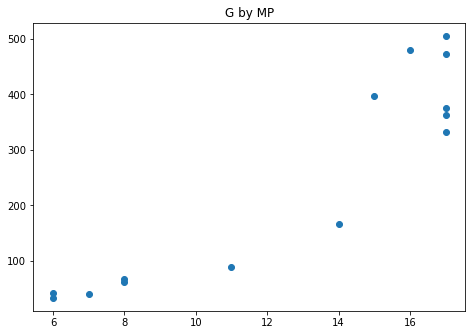

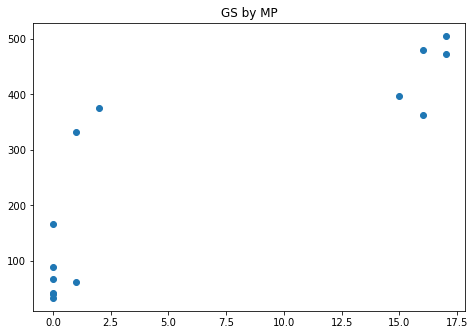

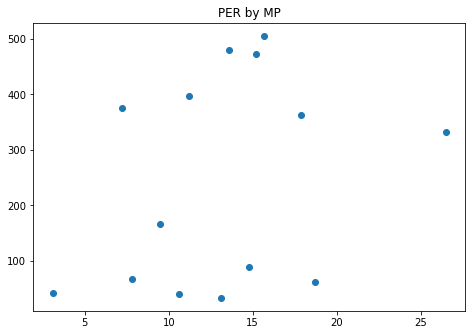

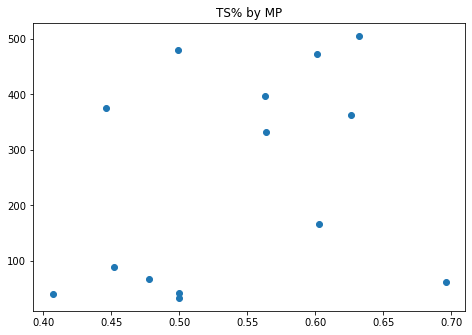

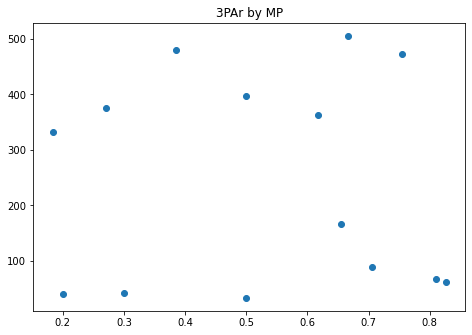

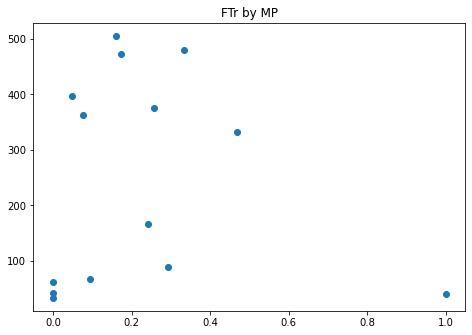

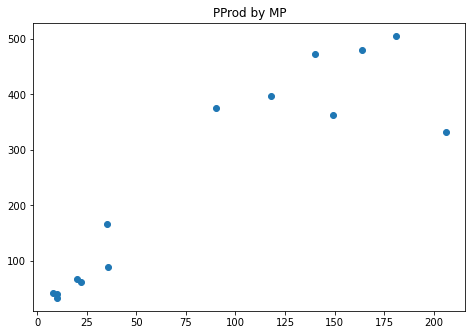

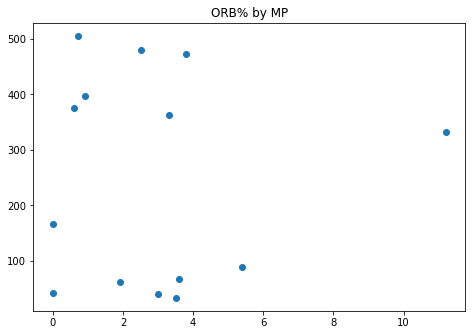

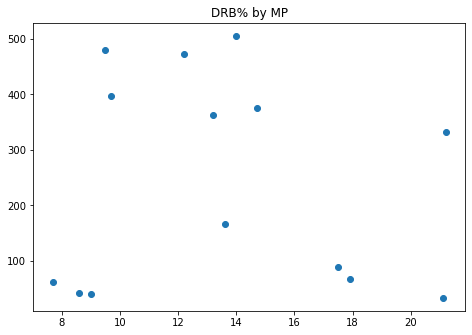

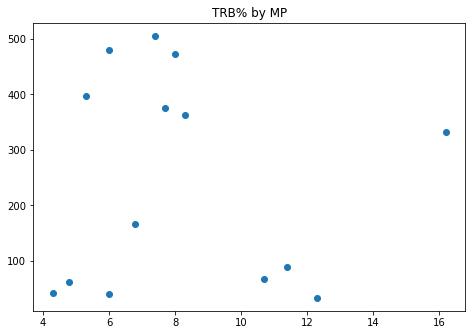

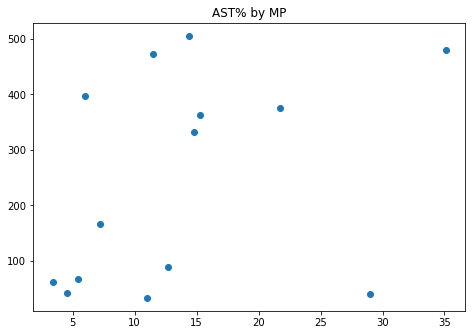

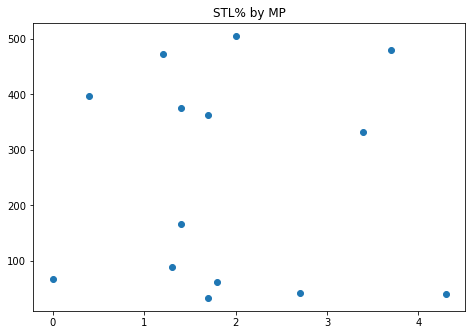

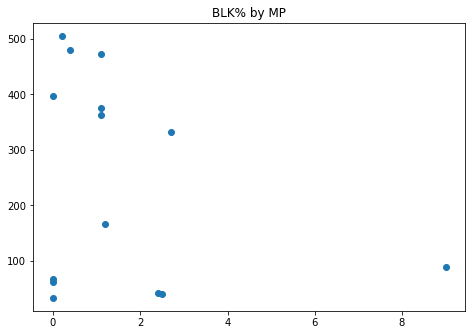

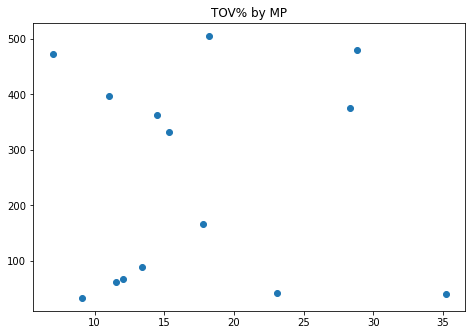

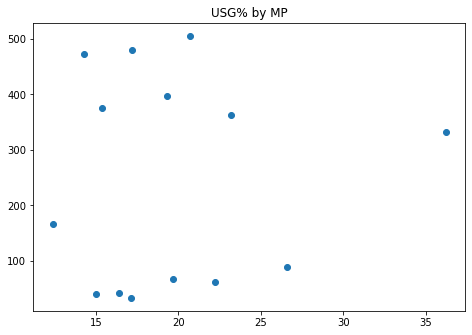

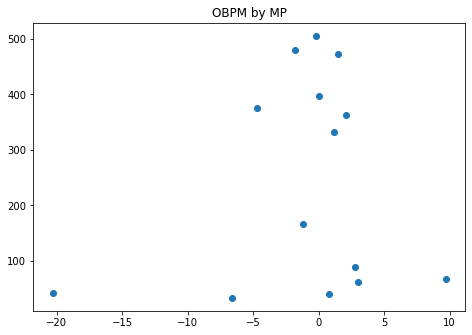

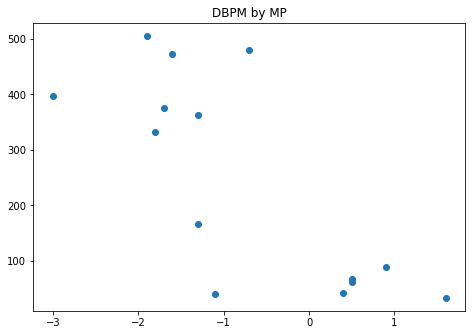

In [7]:
#plot features from advanced in relation to min played
advanced = advanced.set_index('Player')
for col in advanced.columns:
    if col != minutes:
        
        x = advanced[col]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.set_title(col + ' by ' + minutes)
        ax.scatter(x, advanced[minutes])
        plt.show()


In [19]:
model = ols(formula = 'MP ~ 1 + AST', data = data).fit()
model.summary()

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MP   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     12.07
Date:                Mon, 31 May 2021   Prob (F-statistic):            0.00459
Time:                        21:05:12   Log-Likelihood:                -46.149
No. Observations:                  14   AIC:                             96.30
Df Residuals:                      12   BIC:                             97.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5481      2.554      4.130      0.001       4.983      16.113
AST            4.3607      1.255      3.475      0.005       1.626       7.095
==============================================================================
Omnibus:                        1.668   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.242
Skew:                           0.546   Prob(JB):                        0.537
Kurtosis:                       2.031   Cond. No.                         3.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
data = pergame
formula_103 = 'MP ~ 1 + '

for i in range(1, len(data.columns) - 1):
    if i == (len(data.columns) - 2):
        formula_103 += data.columns[i]
    else:
        formula_103 += data.columns[i] + ' + '
model = ols(formula = formula_103, data = data).fit()
model.summary()

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 31 May 2021   Prob (F-statistic):                nan
Time:                        21:10:13   Log-Likelihood:                 398.19
No. Observations:                  14   AIC:                            -768.4
Df Residuals:                       0   BIC:                            -759.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0015        inf          0        nan         nan         nan
GS                       0.0002        inf          0        nan         nan         nan
MP                       0.9998        inf          0        nan         nan         nan
FG                      -0.0032        inf         -0        nan         nan         nan
FGA                     -0.0055        inf         -0        nan         nan         nan
two_pointers             0.0029        inf          0        nan         nan         nan
two_point_attempts       0.0060        inf          0        nan         nan         nan
three_pointers           0.0062        inf          0        nan         nan         nan
three_point_attempts     0.0037        inf          0        nan         nan         nan
FT                       0.0042        inf          0        nan         nan         nan
FTA                     -0.0028        inf         -0        nan         nan         nan
ORB                     -0.0002        inf         -0        nan         nan         nan
DRB                      0.0008        inf          0        nan         nan         nan
AST                      0.0006        inf          0        nan         nan         nan
STL                     -0.0025        inf         -0        nan         nan         nan
BLK                      0.0018        inf          0        nan         nan         nan
==============================================================================
Omnibus:                        5.162   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                1.527
Skew:                           0.285   Prob(JB):                        0.466
Kurtosis:                       1.486   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
def MSE(y, yhat):
    return np.mean(np.power(y-yhat, 2))
mse = []
p = len(pergame.columns)
for j in range(p):
    # fit model 
    X1 = pergame.columns[j+1]
    formula = 'MP ~ 1 + %s' % pergame.columns[j+1]
     
    model = ols(formula = formula, data = pergame).fit()

    yhat = model.predict()
    
    mse.append(MSE(pergame['MP'], yhat))

SyntaxError: invalid syntax (<unknown>, line 1)

In [8]:
pergame

,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV
Player,,,,,,,,,,,,,,,,,
Toni Rocak,17,1,19.6,4.8,9.3,4.4,7.6,0.4,1.7,2.8,4.4,1.8,3.5,1.2,1.2,0.5,2.1
Gabe Hadley,17,17,29.7,4.2,8.8,1.8,2.9,2.5,5.9,1.1,1.4,0.2,3.5,2.2,1.1,0.1,2.1
Hugh Baxter,17,16,21.3,3.9,7.7,2.1,2.9,1.8,4.8,0.4,0.6,0.6,2.4,1.5,0.6,0.2,1.4
Bryce Pope,15,15,26.4,3.9,8.4,2.3,4.2,1.7,4.2,0.1,0.4,0.2,2.1,0.8,0.2,0.0,1.1
Jake Killingsworth,17,17,27.8,2.8,6.5,0.8,1.6,2.0,4.9,0.8,1.1,0.9,2.8,1.8,0.6,0.3,0.5
Mikey Howell,16,16,29.9,2.4,6.0,1.7,3.7,0.8,2.3,1.3,2.0,0.6,2.4,6.0,1.9,0.1,2.8
Jace Roquemore,17,2,22.1,1.7,4.1,1.5,3.0,0.2,1.1,0.5,1.1,0.1,2.7,2.8,0.5,0.2,1.8
Martin Tombe,8,1,7.8,1.4,2.9,0.1,0.5,1.3,2.4,0.0,0.0,0.1,0.5,0.1,0.3,0.0,0.4
Matt Gray,11,0,8.1,1.0,3.1,0.4,0.9,0.6,2.2,0.5,0.9,0.4,1.2,0.5,0.2,0.7,0.5
